In [25]:
!python3 -m pip install cython
!python3 -m pip install PyMySQL
!python3 -m pip install SQLAlchemy
!python3 -m pip install google-cloud-storage
!python3 -m pip install --upgrade --quiet scikit-sound
!python3 -m pip install --upgrade --quiet pygame
!python3 -m pip install scikit-learn==0.21rc2

!sudo apt-get -y install ffmpeg
!sudo apt-get -y install python3-pymysql

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.2.14-1~deb9u1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pymysql is already the newest version (0.7.10-1).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.


In [26]:
import sqlalchemy
import numpy as np

from google.cloud import storage
from numpy.fft import fft, ifft
from sksound.sounds import Sound

from tensorflow.keras.models import load_model

In [27]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [28]:
# PASSWORDS AND STUFF HERE

In [29]:
settings = {
   'user': db_user,
   'pass': db_password,
   'host': host,
     'db': db_name
}
url = 'mysql+pymysql://{user}:{pass}@{host}/{db}'.format(**settings)  # 5432 is the default port
db = sqlalchemy.create_engine(url)

def run_query(query):
    with db.connect() as conn:
        rows = []
        for row in conn.execute(query).fetchall():
            rows.append(dict(row.items()))
        return rows
    
regions = run_query("""
    SELECT 
        x.encoding, y.year, x.filename, x.start, x.stop
    FROM 
        wdp_ds.not_silent x
    JOIN 
        wdp_ds.encoding y 
    ON x.encoding = y.encoding;
""")

In [30]:
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')

In [31]:
regions_by_file = {}
for region in regions:
    k = "audio_files/{}/{}".format(region['year'], region['filename'])
    r = region
    if k not in regions_by_file:
        regions_by_file[k] = []
    regions_by_file[k].append(r)
print(len(regions_by_file))

54


In [32]:
class StreamSpectrogram:
    
    def __init__(self, filename, starts, stops, win=32):
        sound = Sound(filename)      
        self.ranges = [x for x in zip(starts, stops)]
        self.starts = starts
        self.stops = stops
        self.data  = sound.data
        self.fs    = sound.rate
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):        
        if self.i < len(self.ranges): 
            start, stop = self.ranges[self.i]
            raw   = self.data[start:stop]
            spec  = fwd_spectrogram(raw) 
            t,d   = spec.shape
            if t > self.win:
                current = []        
                for i in range(self.win, t + 1, self.win // 2):
                    x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
                    mu     = np.mean(x)
                    std    = np.std(x) + 1.0
                    window = (x - mu) / std
                    current.append(window)
                self.i += 1
                return np.stack(current)
            else:
                self.i += 1
                return None
        else:
            raise StopIteration
        
def fwd_spectrogram(audio, win=512, step=256):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [ ]:
encoder = load_model('encoder.h5')
idx     = list(regions_by_file.keys()) 
files   = {}
latent  = [] 
for path in idx:    
    with open("/tmp/audio.m4a", "wb") as file_obj:
        blob = bucket.blob(path)
        blob.download_to_file(file_obj)
    stream = StreamSpectrogram("/tmp/audio.m4a", [r['start'] for r in regions_by_file[path]], [r['stop'] for r in regions_by_file[path]])
    for i, region in enumerate(stream):
        r = regions_by_file[path][i]
        x = region
        if x is not None:
            h = encoder.predict(x)
            latent.append([h, r])

Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!
Infile converted from .m4a to ".wav"
data read in!


In [ ]:
import pickle
pickle.dump( latent, open( "data.p", "wb" ) )

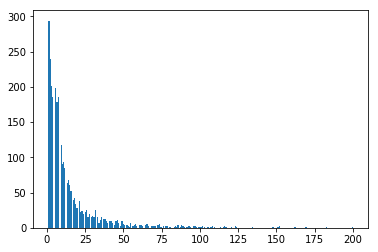

In [1]:
import pickle
import matplotlib.pyplot as plt

latent = pickle.load( open( "data.p", "rb" ) )
x = [len(l[0]) for l in latent]
plt.hist(x, bins=250)
plt.show()

In [6]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(0, m+1):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                dp[i - 1][j    ],
                dp[i    ][j - 1]
            )
    return dp[n][m]

latent = pickle.load( open( "data.p", "rb" ) )
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        if abs(len(x[0]) - len(y[0])) < 10 and i < j:  
            distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

0 / 3016
10 / 3016
20 / 3016
30 / 3016
40 / 3016
50 / 3016
60 / 3016
70 / 3016
80 / 3016
90 / 3016
100 / 3016
110 / 3016
120 / 3016
130 / 3016
140 / 3016
150 / 3016
160 / 3016
170 / 3016
180 / 3016
190 / 3016
200 / 3016
210 / 3016
220 / 3016
230 / 3016
240 / 3016
250 / 3016
260 / 3016
270 / 3016
280 / 3016
290 / 3016
300 / 3016
310 / 3016
320 / 3016
330 / 3016
340 / 3016
350 / 3016
360 / 3016
370 / 3016
380 / 3016
390 / 3016
400 / 3016
410 / 3016
420 / 3016
430 / 3016
440 / 3016
450 / 3016
460 / 3016
470 / 3016
480 / 3016
490 / 3016
500 / 3016
510 / 3016
520 / 3016
530 / 3016
540 / 3016
550 / 3016
560 / 3016
570 / 3016
580 / 3016
590 / 3016
600 / 3016
610 / 3016
620 / 3016
630 / 3016
640 / 3016
650 / 3016
660 / 3016
670 / 3016
680 / 3016
690 / 3016
700 / 3016
710 / 3016
720 / 3016
730 / 3016
740 / 3016
750 / 3016
760 / 3016
770 / 3016
780 / 3016
790 / 3016
800 / 3016
810 / 3016
820 / 3016
830 / 3016
840 / 3016
850 / 3016
860 / 3016
870 / 3016
880 / 3016
890 / 3016
900 / 3016
910 / 3016

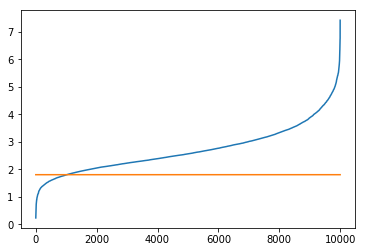

1.8070902029673257


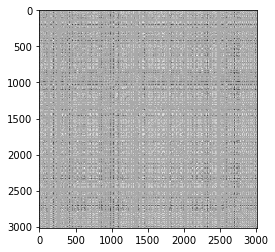

In [15]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

for i in range(len(distances)):
    for j in range(len(distances)):
        if not np.isinf(distances[i][j]):
            distances[i][j] /= len(latent[i][0]) + len(latent[j][0])

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 10)

plt.plot(sorted(f[0:10000]))
plt.plot(np.ones(10000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]
        if np.isinf(distances[i][j]):
            distances[i][j] = th + 1

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [16]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [17]:
import pickle
import matplotlib.pyplot as plt
latent = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances_normal.p", "rb" ) )

In [18]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [19]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='complete', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [20]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    latent[i][1:][0]['cluster'] = cluster_id
    c[cluster_id].append(latent[i][1:][0])

In [21]:
final_clustering = [c for c in c if len(c) >= 2]
print(len(final_clustering))
print([len(c) for c in final_clustering])
print(sum([len(c) for c in final_clustering]))

480
[5, 2, 2, 4, 17, 3, 2, 5, 17, 2, 6, 31, 2, 16, 5, 6, 4, 5, 3, 2, 3, 5, 11, 2, 6, 3, 3, 4, 5, 7, 2, 2, 2, 3, 2, 5, 6, 5, 3, 2, 3, 3, 2, 3, 2, 6, 7, 4, 2, 12, 5, 2, 3, 2, 3, 3, 4, 2, 2, 6, 3, 2, 3, 2, 2, 2, 3, 4, 30, 2, 2, 3, 2, 4, 2, 2, 4, 3, 2, 13, 3, 11, 2, 2, 2, 3, 5, 3, 10, 8, 6, 2, 4, 2, 3, 2, 3, 2, 7, 4, 5, 5, 2, 32, 2, 12, 2, 2, 4, 3, 4, 2, 2, 2, 3, 12, 5, 2, 2, 3, 4, 3, 2, 4, 10, 3, 12, 2, 5, 6, 3, 17, 5, 8, 14, 10, 4, 7, 2, 2, 3, 5, 2, 2, 2, 7, 6, 2, 3, 5, 3, 4, 4, 25, 10, 27, 2, 3, 6, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 59, 4, 2, 14, 2, 3, 3, 2, 2, 2, 3, 3, 8, 2, 2, 3, 2, 2, 3, 2, 8, 12, 3, 7, 2, 2, 5, 5, 6, 2, 7, 3, 2, 3, 2, 2, 10, 3, 2, 3, 13, 2, 5, 2, 8, 19, 2, 10, 2, 14, 4, 2, 2, 3, 5, 7, 2, 4, 2, 2, 3, 3, 2, 5, 2, 3, 6, 2, 2, 3, 2, 4, 3, 2, 2, 3, 3, 4, 2, 29, 2, 2, 2, 2, 3, 6, 2, 3, 7, 2, 5, 8, 2, 4, 2, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 2, 4, 3, 7, 2, 5, 5, 2, 9, 5, 2, 3, 4, 8, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 5, 32, 2, 3, 2, 3, 2, 2, 2, 6, 4, 2, 2, 4, 9, 2, 2, 26, 3, 

In [24]:
from scipy.io import wavfile

print(len(final_clustering))
print([len(c) for c in final_clustering])

print("CLUSTERS: ", len(final_clustering))
client = storage.Client.from_service_account_json('secret.json')
bucket = client.get_bucket('wdp-data')
cx = 0
for cluster in final_clustering:
    n = len(cluster)
    print("Cluster: {}".format(n))
    
    audio = []
    for i, region in enumerate(cluster):
        path = "audio_files/{}/{}".format(region['year'], region['filename'])
        with open("/tmp/audio.m4a", "wb") as file_obj:
            blob = bucket.blob(path)
            blob.download_to_file(file_obj)
        stream = StreamSpectrogram("/tmp/audio.m4a", [region['start']], [region['stop']])
        spec = fwd_spectrogram(stream.data[region['start']:region['stop']])
        audio.extend(stream.data[region['start']:region['stop']])
        audio.extend(np.zeros(stream.fs // 10))    
                
    audio = np.array(audio, dtype=audio[0].dtype)
    wavfile.write('results/cluster_{}.wav'.format(cx), stream.fs, audio)
    cx += 1
    plt.show()

480
[5, 2, 2, 4, 17, 3, 2, 5, 17, 2, 6, 31, 2, 16, 5, 6, 4, 5, 3, 2, 3, 5, 11, 2, 6, 3, 3, 4, 5, 7, 2, 2, 2, 3, 2, 5, 6, 5, 3, 2, 3, 3, 2, 3, 2, 6, 7, 4, 2, 12, 5, 2, 3, 2, 3, 3, 4, 2, 2, 6, 3, 2, 3, 2, 2, 2, 3, 4, 30, 2, 2, 3, 2, 4, 2, 2, 4, 3, 2, 13, 3, 11, 2, 2, 2, 3, 5, 3, 10, 8, 6, 2, 4, 2, 3, 2, 3, 2, 7, 4, 5, 5, 2, 32, 2, 12, 2, 2, 4, 3, 4, 2, 2, 2, 3, 12, 5, 2, 2, 3, 4, 3, 2, 4, 10, 3, 12, 2, 5, 6, 3, 17, 5, 8, 14, 10, 4, 7, 2, 2, 3, 5, 2, 2, 2, 7, 6, 2, 3, 5, 3, 4, 4, 25, 10, 27, 2, 3, 6, 2, 4, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 59, 4, 2, 14, 2, 3, 3, 2, 2, 2, 3, 3, 8, 2, 2, 3, 2, 2, 3, 2, 8, 12, 3, 7, 2, 2, 5, 5, 6, 2, 7, 3, 2, 3, 2, 2, 10, 3, 2, 3, 13, 2, 5, 2, 8, 19, 2, 10, 2, 14, 4, 2, 2, 3, 5, 7, 2, 4, 2, 2, 3, 3, 2, 5, 2, 3, 6, 2, 2, 3, 2, 4, 3, 2, 2, 3, 3, 4, 2, 29, 2, 2, 2, 2, 3, 6, 2, 3, 7, 2, 5, 8, 2, 4, 2, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 2, 4, 3, 7, 2, 5, 5, 2, 9, 5, 2, 3, 4, 8, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 5, 32, 2, 3, 2, 3, 2, 2, 2, 6, 4, 2, 2, 4, 9, 2, 2, 26, 3, 

KeyboardInterrupt: 

In [ ]:
with db.connect() as conn:
    id = 0
    for cluster in final_clustering:
        for r in cluster:
            query = "INSERT INTO wdp_ds.clustering_results VALUES({}, {}, '{}', {}, {}, '{}', {}, CURRENT_TIMESTAMP)".format(
                id, r['encoding'], r['filename'], r['start'], r['stop'], 'agglomerative_dtw_lstmv2', r['cluster'])        
            conn.execute(query)  
            id += 1